### Try using code from 'chroma' package. First, add ./chroma/chroma to PYTHONPATH.

In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cPickle

import dcr
import spec
import plot
import utils

#import _mypath
#import chroma

datadir = './chroma/data/'

%matplotlib inline

Code from chroma/bin/intuition/refraction.py

This makes Figure 1 from the Meyers and Burchat (2015) paper.

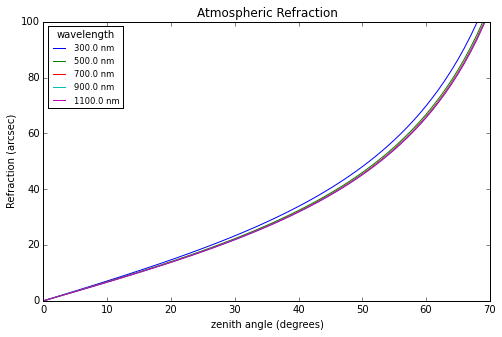

In [15]:
def refraction_vs_zenith():
    zeniths = np.linspace(0, 70, 71) # degrees
    waves = np.arange(300, 1101, 200, dtype=np.float64) # nm

    # open figure for output
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(111)
    ax.set_title('Atmospheric Refraction')
    ax.set_xlabel('zenith angle (degrees)')
    ax.set_xlim(0, 70)
    ax.set_ylabel('Refraction (arcsec)')
    ax.set_ylim(0, 100)

    for wave in waves:
        refrac_angles = np.array([dcr.get_refraction(wave, z * np.pi/180) for z in zeniths])
        ax.plot(zeniths, refrac_angles * 3600 * 180/np.pi, label=str(wave)+' nm')
    ax.legend(fontsize='small', title='wavelength', loc='upper left')
    if not os.path.isdir('output/'):
        os.mkdir('output/')
    fig.savefig('output/refraction_vs_zenith.png', dpi=220)
    #return fig

refraction_vs_zenith()

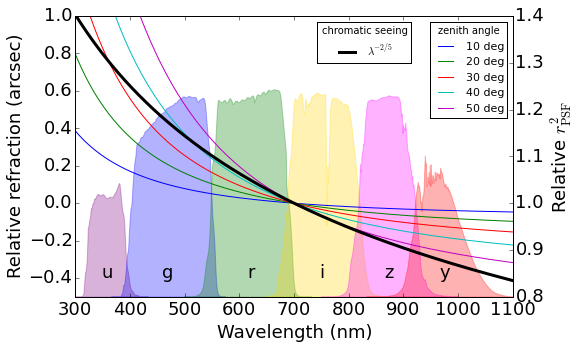

In [49]:
def chromatic_biases(offset_wave=700.):
    zeniths = [10, 20, 30, 40, 50]
    waves = np.arange(300, 1101, 1, dtype=np.float64)

    fig = plt.figure(figsize=(8,5))
    #ax = fig.add_subplot(111)
    ax = fig.add_axes([0.14, 0.13, 0.76, 0.78])
    ax.set_xlabel('Wavelength (nm)', fontsize=18)
    ax.set_xlim(300, 1200)
    ax.set_ylabel('Relative refraction (arcsec)', fontsize=18)
    ax.set_ylim(-0.5, 1.)

    for zenith in zeniths:
        # chroma expects angles in radians, so need to convert deg to radians
        refrac_angle = dcr.get_refraction(waves, zenith * np.pi/180.0)
        refrac_ref = refrac_angle[np.argmin(abs(waves - offset_wave))]
        # chroma output is also in radians, so convert to arcsec here
        ax.plot(waves, (refrac_angle - refrac_ref) * 206265.0, label=str(zenith)+' deg')

    # 350nm wide Euclid filter.
    # ax.fill_between([0., 550., 550., 900., 900., 1200.], [-1, -1, 0.25, 0.25, -1, -1], -1,
    #                 color='black', alpha=0.15)

    colors = ['purple', 'blue', 'green', 'gold', 'magenta', 'red']
    for i, filter_ in enumerate('ugrizy'):
        # filters are stored in two columns: wavelength (nm), and throughput
        fdata = spec.Bandpass(datadir+'filters/LSST_{}.dat'.format(filter_))
        fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
        ax.fill_between(fwave, throughput * 2.0 - 0.5, -0.5, color=colors[i], alpha=0.3)
    # Add in lambda^(-2/5) for chromatic seeing comparison integrand comparison
    ax2 = ax.twinx()
    ys = (waves/offset_wave)**(-2./5)
    ax2.plot(waves, ys, 'k', lw=3, label='$\lambda^{-2/5}$')
    ax.legend(fontsize=11, title='zenith angle')
    ax2.legend(fontsize=11, title='chromatic seeing', loc='upper right', bbox_to_anchor = (0.78, 1))
    ax2.set_xlim(300, 1100)
    ax2.set_ylim(0.8, 1.4)
    ax2.set_ylabel('Relative $r^2_\mathrm{PSF}$', fontsize=18)

    ax.text(350.0, -0.4, 'u', fontsize=18)
    ax.text(460.0, -0.4, 'g', fontsize=18)
    ax.text(618.0, -0.4, 'r', fontsize=18)
    ax.text(750.0, -0.4, 'i', fontsize=18)
    ax.text(867.0, -0.4, 'z', fontsize=18)
    ax.text(967.0, -0.4, 'y', fontsize=18)

    for label in ax.get_xticklabels():
        label.set_fontsize(18)
    for label in ax.get_yticklabels():
        label.set_fontsize(18)
    for label in ax2.get_yticklabels():
        label.set_fontsize(18)

    if not os.path.isdir('output/'):
        os.mkdir('output/')
    fig.savefig('output/chromatic_biases_700.png', dpi=220)
    fig.savefig('output/chromatic_biases_700.pdf')
    #return fig
    
chromatic_biases(700.)
#chromatic_biases(500.)

Now code from chroma/bin/where_the_photons_land.py  (Figure 2)

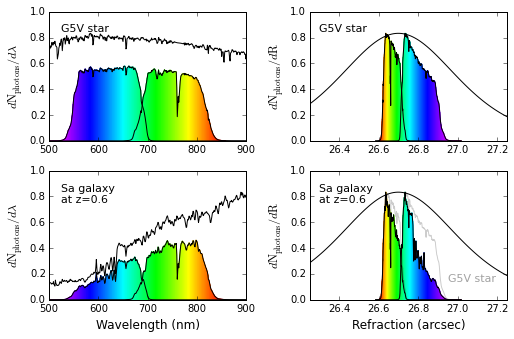

In [36]:
def moffat1d(fwhm, beta, center=0.0):
    alpha = fwhm / (2.0 * np.sqrt(2.0**(1./beta) - 1.0))
    def f(x):
        u = ((x - center) / alpha)**2
        p = 1.0 / ((u + 1.0)**beta)
        return p / p.max()
    return f

zspifig, ax = plt.subplots(2, 2, figsize=(8,5))

#spectra = ['../../data/SEDs/'+s for s in ('ukg5v.ascii', 'CWW_Sbc_ext.ascii')]
spectra = [datadir+'/SEDs/'+s for s in ('ukg5v.ascii', 'KIN_Sa_ext.ascii')]
specnames = ['G5V star', 'Sa galaxy\nat z=0.6']
ytextoffset = [0, -0.1]
redshifts = [0.0, 0.6]
filters = [datadir+'/filters/'+s for s in ('LSST_r.dat', 'LSST_i.dat')]

psf_fwhm = 0.7
psf_beta = 3.0
zenith_angle = 35 * np.pi/180

ax[1,0].set_xlabel('Wavelength (nm)', fontsize=12)
ax[1,1].set_xlabel('Refraction (arcsec)', fontsize=12)
for i, s in enumerate(spectra):
    SED = spec.SED(s)
    SED = SED.atRedshift(redshifts[i])
    wave = np.arange(500.0, 901.0, 1.0)
    photons = SED(wave)
    scale = 1.2 * photons[(wave > 500) & (wave < 900)].max()
    ax[i,0].plot(wave, photons/scale, color='black')
    ax[i,0].set_xlim(500, 900)
    ax[i,0].set_ylim(0.0, 1.0)
    ax[i,0].set_ylabel('$d\mathrm{N_{photons}}/d\lambda$', fontsize=12)
    ax[i,0].text(525, 0.85+ytextoffset[i], specnames[i], fontsize=11)
    ax[i,1].set_ylim(0.0, 1.0)
    ax[i,1].set_ylabel('$d\mathrm{N_{photons}}/d\mathrm{R}$', fontsize=12)

    ax[i,1].text(26.30, 0.85+ytextoffset[i], specnames[i], fontsize=11)
    xs = np.linspace(26.25, 27.25, 100)
    moffat = moffat1d(fwhm=psf_fwhm, beta=psf_beta, center=26.7)
    ax[i,1].plot(xs, moffat(xs)/1.2, color='black')
    ax[i,1].set_xlim(26.25, 27.25)

    for f in filters:
        filter_ = spec.Bandpass(f).truncate(blue_limit=500, red_limit=1000)
        photons_filtered = photons * filter_(wave)
        color = np.interp(wave, cwave, np.linspace(1.0, 0.0, 256))

        R = dcr.get_refraction(wave, zenith_angle) * 3600 * 180/np.pi
        dR = np.diff(R)
        dwave = np.diff(wave)
        dwave_dR = dwave / dR # Jacobian
        dwave_dR = np.append(dwave_dR, dwave_dR[-1]) # fudge the last array element
        angle_dens = photons_filtered * np.abs(dwave_dR)

        # first axis is normal spectrum
        ax[i,0].plot(wave, 1.3 * photons_filtered/scale, color='black')
        ax[i,0].xaxis.set_ticks([500, 600, 700, 800, 900])
        plot.chroma_fill_between(wave, 1.3 * photons_filtered/scale, 0, c=color, axes=ax[i,0])

        # second axis is photons binned by refraction
        ax[i,1].plot(R, angle_dens/angle_dens.max() / 1.2, color='black')
        plot.chroma_fill_between(R, angle_dens/angle_dens.max() / 1.2, 0, c=color, axes=ax[i,1])
        if i==0:
            ax[1,1].plot(R, angle_dens/angle_dens.max() / 1.2, color='black', alpha=0.2)
            ax[1,1].text(26.95, 0.14, specnames[0], fontsize=11, alpha=0.2)

        for label in ax[i,1].get_xticklabels():
            label.set_fontsize(10)
        for label in ax[i,1].get_yticklabels():
            label.set_fontsize(10)
        for label in ax[i,0].get_xticklabels():
            label.set_fontsize(10)
        for label in ax[i,0].get_yticklabels():
            label.set_fontsize(10)

fig.subplots_adjust(hspace=0.23, wspace=0.32, bottom=0.12, right=0.92, top=0.92)
plt.savefig('output/photon_landings.png', dpi=220)
plt.savefig('output/photon_landings.pdf')

Now let's try to generate Figure 5... 
First, make the stars/galaxies catalog from the SEDs. This is from chroma/bin/analytic/analytic_table.py

Create tables of AB magnitudes and chromatic biases from a variety of spectra.

For stars, we use the spectra from Pickles (1998), (the 'uk*.ascii' files in the data/SEDs/
subdirectory).

For galaxies, we use spectra from Coleman et al. (1980) (CWW*.ascii files), and Kinney et al. (1996)
(KIN*.ascii files)

The chromatic biases computed are:
  - the shift in PSF centroid due to differential chromatic refraction
  - the shift in PSF zenith-direction second moment due to differential chromatic refraction
  For LSST filters:
  - the shift in PSF second moment square radius (Ixx + Iyy) due to chromatic seeing
  For Euclid filters:
  - the shift in PSF second moment square radius due to a pure diffraction limited PSF
  - the shift in PSF second moment square radius with a FWHM \propto \lambda^{0.6} dependence,
    which is appropriate for Euclid (Cypriano et al. (2010), Voigt et al. (2012)).

For stars, only redshift 0 is considered.
For galaxies, magnitudes and biases are computed over a range of redshifts.

In [28]:
# Define some useful numpy dtypes.
# LSST filters

spec_dir = './chroma/data/SEDs/'
filter_dir = './chroma/data/filters/'
    
ugrizy =  [('LSST_u', np.float),
           ('LSST_g', np.float),
           ('LSST_r', np.float),
           ('LSST_i', np.float),
           ('LSST_z', np.float),
           ('LSST_y', np.float)]
# The Euclid telescope will fly with one optical filter, nominally of width 350nm.  We include
# additional potential optical filters here to see the effect of filter width on chromatic biases,
# as was done in Voigt et al. (2012)
E =       [('Euclid_150', np.float),
           ('Euclid_250', np.float),
           ('Euclid_350', np.float),
           ('Euclid_450', np.float)]
# Both LSST and Euclid
ugrizyE = [('LSST_u', np.float),
           ('LSST_g', np.float),
           ('LSST_r', np.float),
           ('LSST_i', np.float),
           ('LSST_z', np.float),
           ('LSST_y', np.float),
           ('Euclid_150', np.float),
           ('Euclid_250', np.float),
           ('Euclid_350', np.float),
           ('Euclid_450', np.float)]

def compute_mags_moments(sed, filters):
    """ Given an SED and some filters, compute magnitudes and chromatic biases.
    """
    out = np.recarray((1,), dtype = [('mag', ugrizyE),   # AB magnitude
                                     ('Rbar', ugrizy),   # DCR centroid shift
                                     ('V', ugrizy),      # DCR second moment shift
                                     ('S_m02', ugrizy),  # PSF size shift with exponent -0.2
                                     ('S_p06', E),       # same, but exponent = +0.6
                                     ('S_p10', E),       # same, but exponent = +1.0
                                     ('linear', ugrizyE)]) #LinearSecondMomentShift
    for filter_name, bandpass in filters.iteritems():
        w_eff = bandpass.effective_wavelength
        beta_slope = 1.e-5 #arcsec^2/nm
        beta_slope *= (1./3600 * np.pi/180)**2 # -> rad^2/nm
        # some magnitude calculations will fail because the SED doesn't cover the wavelength range
        # of the bandpass filter.  Catch these here.
        try:
            out[0]['mag'][filter_name] = sed.calculateMagnitude(bandpass)
        except ValueError:
            out[0]['mag'][filter_name] = np.nan
        if filter_name.startswith('Euclid'):
            # For Euclid filters, investigate both a FWHM \propto \lambda^1.0 chromatic PSF (pure
            # diffraction limit), and a FWHM \propto \lambda^0.6 chromatic PSF (which is more
            # likely given the additional contribution to the Euclid PSF from CCDs and jitter (see
            # Cypriano et al. 2010)
            try:
                out[0]['S_p06'][filter_name] = sed.calculateSeeingMomentRatio(bandpass, alpha=0.6)
                out[0]['S_p10'][filter_name] = sed.calculateSeeingMomentRatio(bandpass, alpha=1.0)
                out[0]['linear'][filter_name] = sed.calculateLinearMomentShift(bandpass,
                                                                               beta_slope,
                                                                               700.0)
            except ValueError:
                out[0]['S_p06'][filter_name] = np.nan
                out[0]['S_p10'][filter_name] = np.nan
                out[0]['linear'][filter_name] = np.nan
        else:
            # For LSST filters, compute shifts in the zenith-direction first and second moments of
            # the PSF due to differential chromatic refraction.  Store results for a zenith angle of
            # 45 degrees, which can easily be scaled later by tan(zenith_angle) and
            # tan^2(zenith_angle) for the shift in first and second moments respectively.
            #
            # Also compute shift in PSF second moment square radius due to \lambda^{-0.2} chromatic
            # seeing.
            try:
                DCR_mom = sed.calculateDCRMomentShifts(bandpass, zenith_angle=np.pi/4)
                out[0]['Rbar'][filter_name] = DCR_mom[0][1,0]
                out[0]['V'][filter_name] = DCR_mom[1][1,1]
                out[0]['S_m02'][filter_name] = sed.calculateSeeingMomentRatio(bandpass, alpha=-0.2)
                out[0]['linear'][filter_name] = sed.calculateLinearMomentShift(bandpass,
                                                                               beta_slope,
                                                                               w_eff)
            except ValueError:
                out[0]['Rbar'][filter_name] = np.nan
                out[0]['V'][filter_name] = np.nan
                out[0]['S_m02'][filter_name] = np.nan
                out[0]['linear'][filter_name] = np.nan
    return out

def construct_analytic_table():
    # define SED types
    star_types = ['uko5v',
                  'ukb5iii',
                  'uka5v',
                  'ukf5v',
                  'ukg5v',
                  'ukk5v',
                  'ukm5v']
    gal_types= ['CWW_E_ext',
                'KIN_Sa_ext',
                'KIN_Sb_ext',
                'CWW_Sbc_ext',
                'CWW_Scd_ext',
                'CWW_Im_ext',
                'KIN_SB1_ext',
                'KIN_SB6_ext']

    # load filters
    filter_names = ['LSST_u', 'LSST_g', 'LSST_r', 'LSST_i', 'LSST_z', 'LSST_y',
                   'Euclid_150', 'Euclid_250', 'Euclid_350', 'Euclid_450']
    filters = {}
    for f in filter_names:
        filters[f] = (spec.Bandpass(filter_dir + '{}.dat'.format(f))
                      .withZeropoint('AB', effective_diameter=6.4, exptime=30.0))

    # start with stars
    star_data = np.recarray((len(star_types),), dtype = [('star_type', 'a11'),
                                                         ('mag', ugrizyE),
                                                         ('Rbar', ugrizy),
                                                         ('V', ugrizy),
                                                         ('S_m02', ugrizy),
                                                         ('S_p06', E),
                                                         ('S_p10', E),
                                                         ('linear', ugrizyE)])
    for i, star_type in enumerate(star_types):
        star_SED = spec.SED(spec_dir + star_type + '.ascii')
        data = compute_mags_moments(star_SED, filters)
        star_data[i]['star_type'] = star_type
        for name in data.dtype.names:
            star_data[i][name] = data[name]
    if not os.path.isdir('output'):
        os.mkdir('output')
    cPickle.dump(star_data, open('output/stars.pkl', 'wb'))

    # now onto galaxies
    gal_data = np.recarray((len(gal_types)*100,), dtype = [('gal_type', 'a11'),
                                                           ('redshift', np.float),
                                                           ('mag', ugrizyE),
                                                           ('Rbar', ugrizy),
                                                           ('V', ugrizy),
                                                           ('S_m02', ugrizy),
                                                           ('S_p06', E),
                                                           ('S_p10', E),
                                                           ('linear', ugrizyE)])
    i=0
    with utils.ProgressBar(100 * len(gal_types)) as bar:
        for gal_type in gal_types:
            gal_SED0 = spec.SED(spec_dir + gal_type + '.ascii')
            for z in np.arange(0.0, 3.0, 0.03):
                bar.update()
                gal_SED = gal_SED0.atRedshift(z)
                data = compute_mags_moments(gal_SED, filters)
                gal_data[i]['gal_type'] = gal_type
                gal_data[i]['redshift'] = z
                for name in data.dtype.names:
                    gal_data[i][name] = data[name]
                i += 1
    cPickle.dump(gal_data, open('output/galaxies.pkl', 'wb'))

construct_analytic_table()

Now make the plots. This plots color corrections as a function of zenith angle. This is from plot_DCR_color_corrections.py

Plot differential chromatic refraction biases as a function of color, fit a trendline, and
also plot the residual.

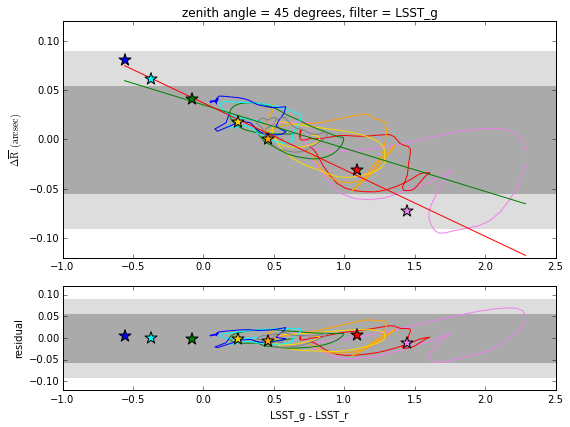

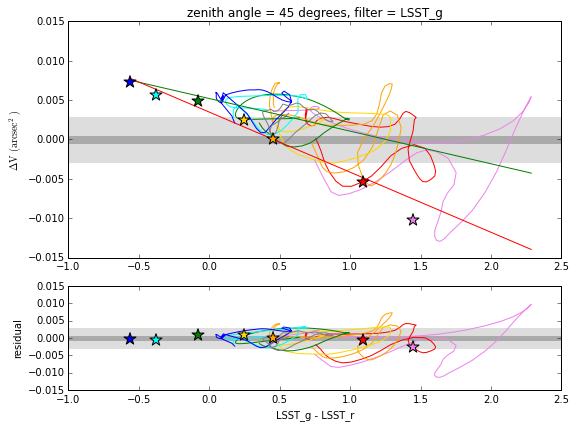

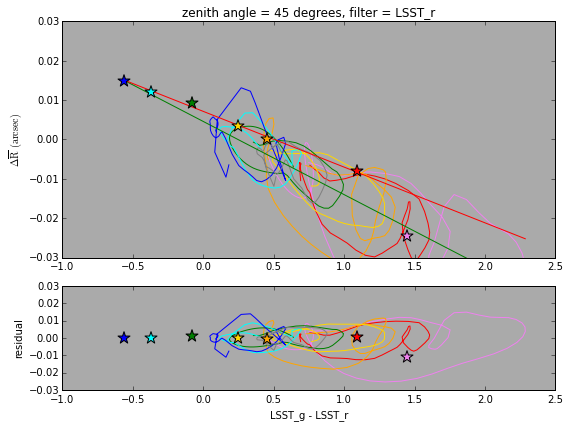

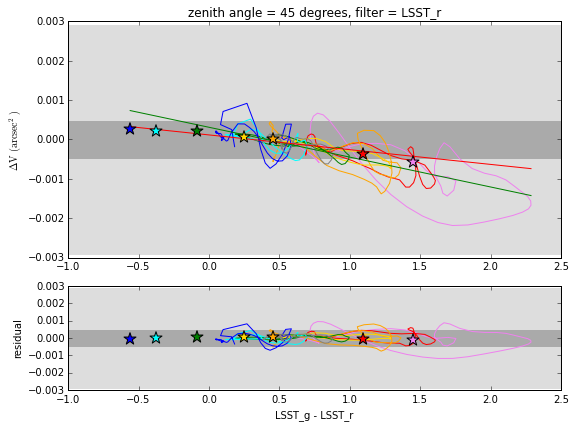

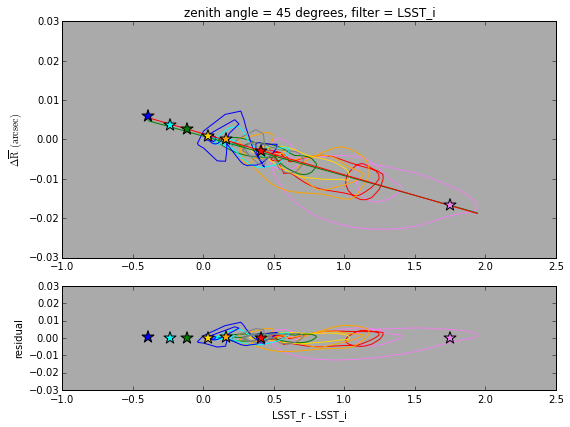

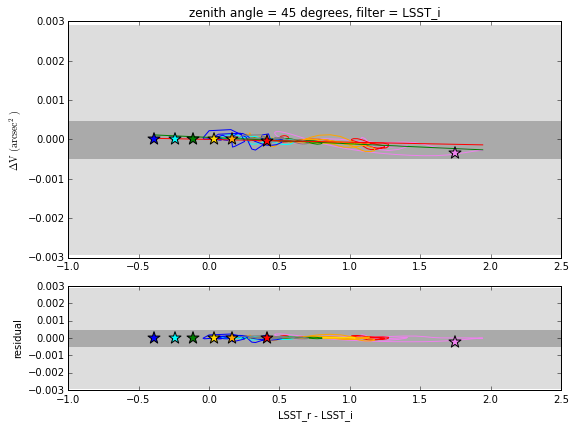

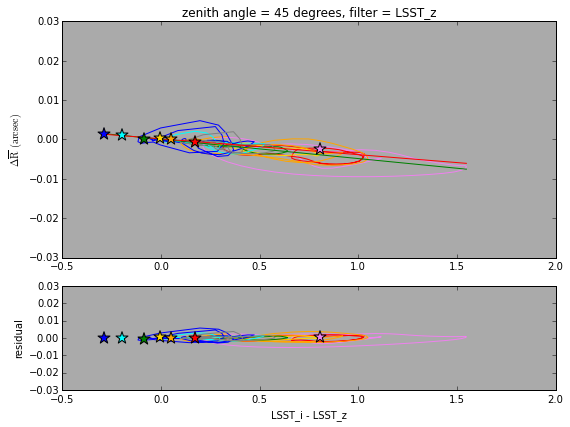

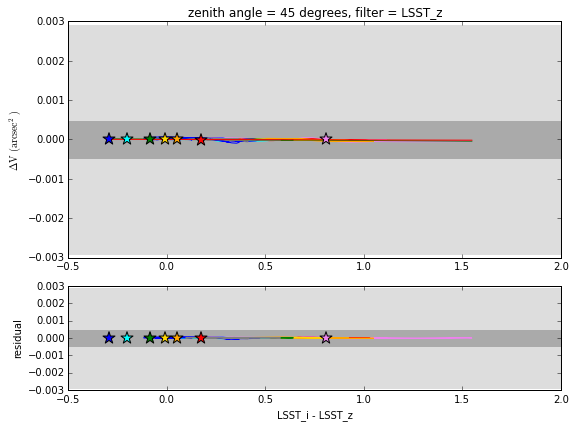

In [29]:
def DCR_color_correction(shape_filter, color_filters):
    stars = cPickle.load(open('output/stars.pkl'))
    gals = cPickle.load(open('output/galaxies.pkl'))

    star_names = ['O5V', 'B5III', 'A5V', 'F5V', 'G5V', 'K5V', 'M5V']
    star_types = ['uko5v', 'ukb5iii', 'uka5v', 'ukf5v', 'ukg5v', 'ukk5v', 'ukm5v']
    star_pcolors = ['Blue', 'Cyan', 'Green', 'Gold', 'Orange', 'Red', 'Violet']

    gal_names = ['E', 'Sa', 'Sb', 'Sbc', 'Scd', 'Im', 'SB1', 'SB6']
    gal_types = ['CWW_E_ext', 'KIN_Sa_ext', 'KIN_Sb_ext', 'CWW_Sbc_ext', 'CWW_Scd_ext',
                 'CWW_Im_ext', 'KIN_SB1_ext', 'KIN_SB6_ext']
    gal_pcolors = ['Violet', 'Red', 'Orange', 'Gold', 'Green', 'Cyan', 'Blue', 'Gray']

    # Normalize all chromatic shifts to the shift for a G5V star.
    G_idx = stars['star_type'] == 'ukg5v'

    # Populate lists of data for stars to plot and fit with
    star_dRbars = []
    star_dVs = []
    star_colors = []
    for star_type in star_types:
        star_idx = stars['star_type'] == star_type
        Rbar = stars[star_idx]['Rbar'][shape_filter]
        V = stars[star_idx]['V'][shape_filter]
        star_dRbars.append((Rbar - stars[G_idx]['Rbar'][shape_filter]) * 180.0 / np.pi * 3600.0)
        star_dVs.append((V - stars[G_idx]['V'][shape_filter]) * (180.0 / np.pi * 3600.0)**2)
        star_colors.append(stars[star_idx]['mag'][color_filters[0]][0]
                           - stars[star_idx]['mag'][color_filters[1]][0])

    # Fit the stars.  Leave out the troublesome M5v star at the end of the list.
    A_star = np.vstack([star_colors[:-1], np.ones(len(star_colors)-1)]).T # design matrix
    slope_star_Rbar, intercept_star_Rbar = np.linalg.lstsq(A_star, star_dRbars[:-1])[0]
    slope_star_V, intercept_star_V = np.linalg.lstsq(A_star, star_dVs[:-1])[0]

    # Make similar lists for galaxies, each element is a list this time to account for the
    # varying redshifts.
    gal_dRbars = []
    gal_dVs = []
    gal_colors = []
    for gal_type in gal_types:
        gal_idx = gals['gal_type'] == gal_type
        Rbar = gals[gal_idx]['Rbar'][shape_filter]
        V = gals[gal_idx]['V'][shape_filter]
        gal_dRbars.append((Rbar - stars[G_idx]['Rbar'][shape_filter]) * 180.0 / np.pi * 3600.0)
        gal_dVs.append((V - stars[G_idx]['V'][shape_filter]) * (180.0 / np.pi * 3600.0)**2)
        gal_colors.append(gals[gal_idx]['mag'][color_filters[0]]
                          - gals[gal_idx]['mag'][color_filters[1]])

    # Fit the galaxies.  Treat each redshift as an independent point to be fit.
    gal_all_colors = np.array(gal_colors).flatten()
    gal_all_dRbars = np.array(gal_dRbars).flatten()
    gal_all_dVs = np.array(gal_dVs).flatten()
    w = np.isfinite(gal_all_colors)
    A_gal = np.vstack([gal_all_colors[w], np.ones(len(gal_all_colors[w]))]).T # design matrix
    slope_gal_Rbar, intercept_gal_Rbar = np.linalg.lstsq(A_gal, gal_all_dRbars[w])[0]
    slope_gal_V, intercept_gal_V = np.linalg.lstsq(A_gal, gal_all_dVs[w])[0]

    # Open Rbar figure
    f = plt.figure(figsize=(8,6))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
    ax1.set_ylabel('$\Delta \overline{\mathrm{R}}\,(\mathrm{arcsec})$')
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax2.set_xlabel('{} - {}'.format(*color_filters))
    ax2.set_ylabel('residual')
    ax1.set_title('zenith angle = 45 degrees, filter = {}'.format(shape_filter))

    # Scatter plot stars and residuals
    for dRbar, color, pcolor in zip(star_dRbars, star_colors, star_pcolors):
        ax1.scatter(color, dRbar, c=pcolor, marker='*', s=160, zorder=3)
        ax2.scatter(color, dRbar - (intercept_star_Rbar + slope_star_Rbar * color),
                    c=pcolor, marker='*', s=160, zorder=3)

    # Line plot galaxies and residuals
    for dRbar, color, pcolor in zip(gal_dRbars, gal_colors, gal_pcolors):
        ax1.plot(color, dRbar, c=pcolor)
        ax2.plot(color, dRbar - (intercept_gal_Rbar + slope_gal_Rbar * color), c=pcolor)

    # Plot trendlines
    cmin = np.hstack([gal_all_colors[w], star_colors]).min()
    cmax = np.hstack([gal_all_colors[w], star_colors]).max()
    color_range = np.array([cmin, cmax])
    ax1.plot(color_range, intercept_gal_Rbar + color_range * slope_gal_Rbar)
    ax1.plot(color_range, intercept_star_Rbar + color_range * slope_star_Rbar)
    f.tight_layout()

    xlim = ax2.get_xlim()
    LSST_Rbar_req = np.sqrt(3e-3)
    DES_Rbar_req = np.sqrt(8e-3)
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    ax1.fill_between(xlim, [-DES_Rbar_req]*2, [DES_Rbar_req]*2, color='#DDDDDD', zorder=2)
    ax1.fill_between(xlim, [-LSST_Rbar_req]*2, [LSST_Rbar_req]*2, color='#AAAAAA', zorder=2)
    ax2.fill_between(xlim, [-DES_Rbar_req]*2, [DES_Rbar_req]*2, color='#DDDDDD', zorder=2)
    ax2.fill_between(xlim, [-LSST_Rbar_req]*2, [LSST_Rbar_req]*2, color='#AAAAAA', zorder=2)

    if shape_filter == 'LSST_g':
        ylim = (-0.12, 0.12)
    else:
        ylim = (-0.03, 0.03)
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    f.savefig('output/Rbar_{}_vs_{}-{}.png'.format(shape_filter,
                                                   color_filters[0],
                                                   color_filters[1]), dpi=220)

    # Open V figure
    f = plt.figure(figsize=(8,6))
    ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2)
    ax1.set_ylabel('$\Delta \mathrm{V}\,(\mathrm{arcsec}^2)$')
    ax2 = plt.subplot2grid((3,1), (2,0))
    ax2.set_xlabel('{} - {}'.format(*color_filters))
    ax2.set_ylabel('residual')
    ax1.set_title('zenith angle = 45 degrees, filter = {}'.format(shape_filter))

    # Scatter plot stars and residuals
    for dV, color, pcolor in zip(star_dVs, star_colors, star_pcolors):
        ax1.scatter(color, dV, c=pcolor, marker='*', s=160, zorder=3)
        ax2.scatter(color, dV - (intercept_star_V + slope_star_V * color),
                    c=pcolor, marker='*', s=160, zorder=3)

    # Line plot galaxies and residuals
    for dV, color, pcolor in zip(gal_dVs, gal_colors, gal_pcolors):
        ax1.plot(color, dV, c=pcolor)
        ax2.plot(color, dV - (intercept_gal_V + slope_gal_V * color), c=pcolor)

    # Plot trendlines
    ax1.plot(color_range, intercept_gal_V + color_range * slope_gal_V)
    ax1.plot(color_range, intercept_star_V + color_range * slope_star_V)
    f.tight_layout()

    xlim = ax2.get_xlim()
    LSST_V_req = 4.8e-4
    DES_V_req = 2.9e-3
    ax1.set_xlim(xlim)
    ax2.set_xlim(xlim)
    ax1.fill_between(xlim, [-DES_V_req]*2, [DES_V_req]*2, color='#DDDDDD', zorder=2)
    ax1.fill_between(xlim, [-LSST_V_req]*2, [LSST_V_req]*2, color='#AAAAAA', zorder=2)
    ax2.fill_between(xlim, [-DES_V_req]*2, [DES_V_req]*2, color='#DDDDDD', zorder=2)
    ax2.fill_between(xlim, [-LSST_V_req]*2, [LSST_V_req]*2, color='#AAAAAA', zorder=2)

    if shape_filter == 'LSST_g':
        ylim = (-0.015, 0.015)
    else:
        ylim = (-0.003, 0.003)
    ax1.set_ylim(ylim)
    ax2.set_ylim(ylim)
    f.savefig('output/V_{}_vs_{}-{}.png'.format(shape_filter,
                                                color_filters[0],
                                                color_filters[1]), dpi=220)

# pick values to match PB12
DCR_color_correction('LSST_g', ['LSST_g', 'LSST_r'])
DCR_color_correction('LSST_r', ['LSST_g', 'LSST_r'])
DCR_color_correction('LSST_i', ['LSST_r', 'LSST_i'])
DCR_color_correction('LSST_z', ['LSST_i', 'LSST_z'])